Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


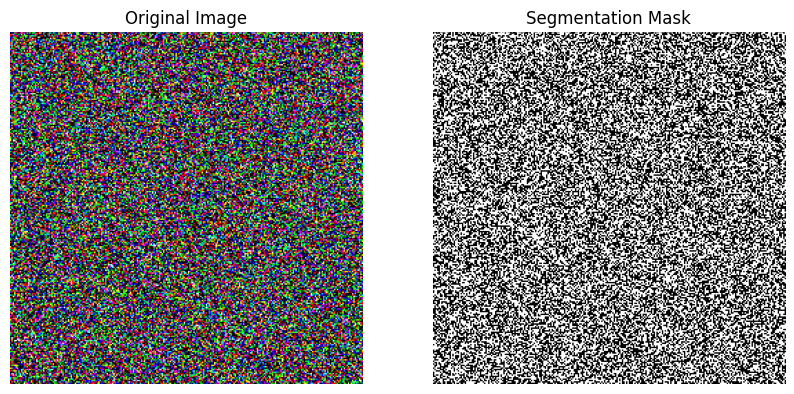

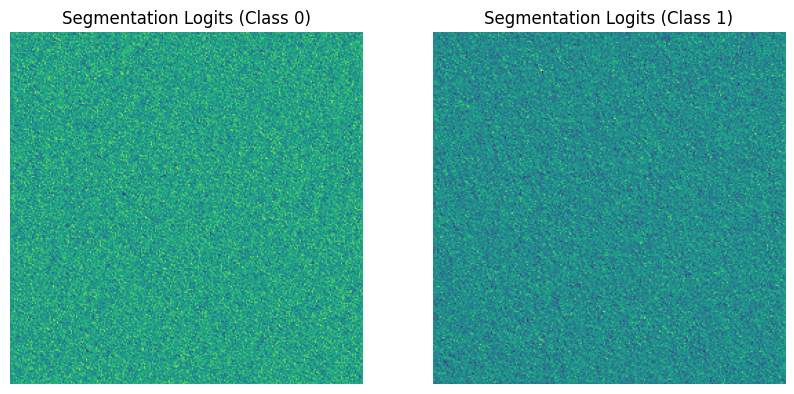

Energy: 11.859387397766113


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SegmentationModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class EnergyBasedModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EnergyBasedModel, self).__init__()
        self.segmentation_model = SegmentationModel(input_channels, num_classes)

    def forward(self, image, segmentation_mask):
        # Calculate the energy function
        segmentation_logits = self.segmentation_model(image)
        
        # Compute data term (e.g., cross-entropy loss)
        data_term = F.cross_entropy(segmentation_logits, segmentation_mask)
        
        # Add regularization term (e.g., L2 regularization)
        regularization_term = 0.0
        for param in self.parameters():
            regularization_term += torch.norm(param, 2)
        
        # Total energy is the sum of data term and regularization term
        energy = data_term + regularization_term
        
        return energy, segmentation_logits

# Example usage
input_channels = 3  # Assuming RGB images
num_classes = 2  # Example: binary segmentation
model = EnergyBasedModel(input_channels, num_classes)

# Example input image and segmentation mask (random)
image = torch.randn(1, input_channels, 256, 256)
segmentation_mask = torch.randint(0, num_classes, (1, 256, 256))

# Plot the original image and segmentation mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask")
plt.imshow(segmentation_mask.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Forward pass to calculate the energy and segmentation logits
energy, segmentation_logits = model(image, segmentation_mask)

# Plot the segmentation logits
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Segmentation Logits (Class 0)")
plt.imshow(segmentation_logits[0, 0].detach().numpy(), cmap='viridis')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmentation Logits (Class 1)")
plt.imshow(segmentation_logits[0, 1].detach().numpy(), cmap='viridis')
plt.axis('off')
plt.show()

print("Energy:", energy.item())
